### Hyperoptimization code adapted from https://github.com/googleinterns/commentaries ####

In [1]:
import copy
import numpy as np
import os
import torch
import torch.nn as nn
import torch.utils.data as utils
import torch.nn.functional as F
import pickle
from torch.utils.data import Dataset, DataLoader, Subset
from torch.autograd import grad

In [2]:
# For determinism
from torch.backends import cudnn
cudnn.deterministic = True
cudnn.benchmark = False

In [3]:
from models import *

In [4]:
import aug_policy

In [5]:
from ptbxl_dataset import PTBXLWrapper

In [6]:
import argparse

In [7]:
parser = argparse.ArgumentParser(description='ECG Learn Aug')
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--epochs', default=100, type=int)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--savefol', type=str, default='taskaug')
parser.add_argument('--checkpoint', type=str)
parser.add_argument('--hyper_lr', type=float, default=1e-2)
parser.add_argument('--warmup_epochs', type=int, default=5)
parser.add_argument('--aug', default='learnmag')
parser.add_argument('--neumann', type=int, default=1)
parser.add_argument('--train_samp', type=int, default=1000)
parser.add_argument('--num_base_steps', type=int, default=1)
parser.add_argument('--task',type=str, default='STTC')
parser.add_argument('--augckpt',type=str, default=None)
parser.add_argument('--testeval', action='store_true')
parser.add_argument('--only_eval', action='store_true')
args, unknown = parser.parse_known_args()

In [8]:
SEED=args.seed
torch.manual_seed(SEED)
import random
random.seed(SEED)
np.random.seed(SEED)

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
print("Is CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
print("Allocated memory (MB):", torch.cuda.memory_allocated() / 1024**2)
print("Reserved memory (MB):", torch.cuda.memory_reserved() / 1024**2)

Is CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4080
Allocated memory (MB): 0.0
Reserved memory (MB): 0.0


In [11]:
if args.augckpt:
    args.savefol += args.augckpt

In [12]:
dataset_wrapper = PTBXLWrapper(args.batch_size)
train_dataloader, val_dataloader, test_dataloader = dataset_wrapper.get_data_loaders(args)

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
def model_saver(epoch, student, aug, opt, hyp_opt, path):
    torch.save({
        'epoch' : epoch,
        'aug_sd': aug.state_dict(),
    }, path + f'/checkpoint_epoch{epoch}.pt')

In [15]:
def get_save_path():
    modfol =  f"""seed{args.seed}-lr{args.lr}-hyperlr{args.hyper_lr}-neumann{args.neumann}-warmup{args.warmup_epochs}-num_base_steps{args.num_base_steps}-trainsamp{args.train_samp}-aug{args.aug}-task{args.task}"""
    pth = os.path.join(args.savefol, modfol)
    os.makedirs(pth, exist_ok=True)
    return pth

In [16]:
def zero_hypergrad(hyper_params):
    """
    :param get_hyper_train:
    :return:
    """
    current_index = 0
    for p in hyper_params:
        p_num_params = np.prod(p.shape)
        if p.grad is not None:
            p.grad = p.grad * 0
        current_index += p_num_params

In [17]:
def store_hypergrad(hyper_params, total_d_val_loss_d_lambda):
    """

    :param get_hyper_train:
    :param total_d_val_loss_d_lambda:
    :return:
    """
    current_index = 0
    for p in hyper_params:
        p_num_params = np.prod(p.shape)
        p.grad = total_d_val_loss_d_lambda[current_index:current_index + p_num_params].view(p.shape)
        current_index += p_num_params

In [18]:
def neumann_hyperstep_preconditioner(d_val_loss_d_theta, d_train_loss_d_w, elementary_lr, num_neumann_terms, model):
    preconditioner = d_val_loss_d_theta.detach()
    counter = preconditioner

    # Do the fixed point iteration to approximate the vector-inverseHessian product
    i = 0
    while i < num_neumann_terms:  # for i in range(num_neumann_terms):
        old_counter = counter

        # This increments counter to counter * (I - hessian) = counter - counter * hessian
        hessian_term = gather_flat_grad(
            grad(d_train_loss_d_w, list(model.parameters()), grad_outputs=counter.view(-1), retain_graph=True))
        counter = old_counter - elementary_lr * hessian_term

        preconditioner = preconditioner + counter
        i += 1
    return elementary_lr * preconditioner

In [19]:
def get_hyper_train_flat(hyper_params):
    return torch.cat([p.view(-1) for p in hyper_params])

In [20]:
def gather_flat_grad(loss_grad):
    return torch.cat([p.reshape(-1) for p in loss_grad]) #g_vector

In [21]:
loss_obj = torch.nn.BCEWithLogitsLoss()
def get_loss(enc, x_batch_ecg, y_batch):
    yhat = enc.forward(x_batch_ecg)
    y_batch = y_batch.float()
    loss = loss_obj(yhat.squeeze(), y_batch.squeeze())
    return loss

In [22]:
def hyper_step(model, aug, hyper_params, train_loader, optimizer, val_loader, elementary_lr, neum_steps):
    zero_hypergrad(hyper_params)
    num_weights = sum(p.numel() for p in model.parameters())

    d_train_loss_d_w = torch.zeros(num_weights).to(device)
    model.train(), model.zero_grad()

    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        x = do_aug(x, y, aug)
            
        train_loss= get_loss(model, x, y)
        optimizer.zero_grad()
        d_train_loss_d_w += gather_flat_grad(grad(train_loss, list(model.parameters()), 
                                                  create_graph=True, allow_unused=True))
        break
    optimizer.zero_grad()

    # Initialize the preconditioner and counter
    # Compute gradients of the validation loss w.r.t. the weights/hypers
    d_val_loss_d_theta = torch.zeros(num_weights).cuda()
    model.train(), model.zero_grad()
    for batch_idx, (x, y) in enumerate(val_loader):
        x = x.to(device)
        y = y.to(device)
        val_loss = get_loss(model, x, y)
        optimizer.zero_grad()
        d_val_loss_d_theta += gather_flat_grad(grad(val_loss, model.parameters(), retain_graph=False))
        break    
    
    preconditioner = d_val_loss_d_theta

    preconditioner = neumann_hyperstep_preconditioner(d_val_loss_d_theta, d_train_loss_d_w, elementary_lr,neum_steps, model)

    
    indirect_grad = gather_flat_grad(
        grad(d_train_loss_d_w, hyper_params, grad_outputs=preconditioner.view(-1)))
    hypergrad = indirect_grad # + direct_Grad

    zero_hypergrad(hyper_params)
    store_hypergrad(hyper_params, -hypergrad)
    return hypergrad

In [23]:
# Utility function to update lossdict
def update_lossdict(lossdict, update, action='append'):
    for k in update.keys():
        if action == 'append':
            if k in lossdict:
                lossdict[k].append(update[k])
            else:
                lossdict[k] = [update[k]]
        elif action == 'sum':
            if k in lossdict:
                lossdict[k] += update[k]
            else:
                lossdict[k] = update[k]
        else:
            raise NotImplementedError
    return lossdict

In [24]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [25]:
# Evaluate student on complete train/test set.
def evaluate(dl, student):
    student.eval()
    net_loss = 0
    correct = 0
    y_pred = []
    y_true = []
    ld = {}
    l_obj = nn.BCEWithLogitsLoss(reduction='sum')
    with torch.no_grad():
        for data, target in dl:
            y_true.append(target.detach().cpu().numpy())
            data, target = data.to(device), target.to(device)
            output = student(data)
            net_loss += l_obj(output.squeeze().float(), target.squeeze().float()).item()  # sum up batch loss
            y_pred.append(output.detach().cpu().numpy())

    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    net_loss /= len(dl.dataset)
    
    try:
        ld['epoch_loss'] = net_loss
        ld['auc'] = roc_auc_score(y_true, y_pred)
        ld['auprc'] = average_precision_score(y_true, y_pred)
    except ValueError:
        ld['epoch_loss'] = net_loss
        ld['auc'] = 0
        ld['auprc'] = 0

    print(ld)
    return ld

In [26]:
def do_aug(xecg, y, aug):
    xret = aug(xecg,y)
    return xret

In [27]:
def train(train_dl, val_dl, test_dl):
    loss_meter = AverageMeter()
    if args.aug == 'learnmag':
        aug = aug_policy.full_policy(learn_mag=True, learn_prob=False).to(device)
        # raise NotImplementedError
    
    hyp_params = list(aug.parameters())
    hyp_optim = torch.optim.RMSprop(hyp_params, lr=args.hyper_lr)
    
    num_outputs = 1
    enc = resnet18(num_outputs=num_outputs).to(device)
    
    optimizer = torch.optim.Adam(enc.parameters(), args.lr)

    if args.checkpoint is None:
        print("No checkpoint! Training from scratch")
        load_ep =0
    else:
        ckpt = torch.load(args.checkpoint)
        enc.load_state_dict(ckpt['student_sd'])
        optimizer.load_state_dict(ckpt['optim_sd'])
        hyp_optim.load_state_dict(ckpt['hyp_optim_sd'])
        aug.load_state_dict(ckpt['aug_sd'])
        load_ep = ckpt['epoch'] + 1
        print("Loaded from ckpt")
        
    if args.augckpt:
        ckpt = torch.load(args.augckpt)
        aug.load_state_dict(ckpt['aug_sd'])
        print("Loaded aug")

    if args.only_eval:
        bestmodel = os.path.join(get_save_path(), 'best_model.ckpt')
        enc.load_state_dict(torch.load(bestmodel))
        load_ep = args.epochs

    train_ld = {'loss' : []}
    val_ld = {'loss' : []}
    test_ld = {}
    
    best_val_loss = np.inf
    best_model = copy.deepcopy(enc.state_dict())
    
    num_neumann_steps = args.neumann
    
    steps = 0
    for epoch in range(load_ep,args.epochs):
        for i, (xecg, y) in enumerate(train_dl):
            enc.train()
            zero_hypergrad(hyp_params)
            xecg = xecg.to(device)
            y = y.to(device)
            # xecg = do_aug(xecg, y, aug)
            # Before augmentation
            original_xecg = xecg.clone().detach().cpu()

            # Apply augmentation
            xecg_aug = do_aug(xecg, y, aug)
            xecg_aug = xecg_aug.detach().cpu()

            # For demonstration, keep only the first batch to avoid memory issues
            if steps == 0:
                plot_orig = original_xecg
                plot_aug = xecg_aug 
            #           
            loss = get_loss(enc, xecg, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch >= args.warmup_epochs and steps % args.num_base_steps == 0 and len(hyp_params) > 0:
                for param_group in optimizer.param_groups:
                    cur_lr = param_group['lr']
                    break

                hypg = hyper_step(enc, aug, hyp_params, train_dl, optimizer, val_dl, cur_lr, num_neumann_steps)
                hypg = hypg.norm().item()
                hyp_optim.step()

            steps += 1
            loss_meter.update(loss.item())
            train_ld['loss'].append(loss.item())


        print("Eval at epoch ", epoch)
        lossdict = evaluate(val_dl, enc)
        val_ld = update_lossdict(val_ld, lossdict)
        cur_val_loss = lossdict['epoch_loss']
        if cur_val_loss < best_val_loss:
            best_val_loss = cur_val_loss
            best_model = copy.deepcopy(enc.state_dict())
        
        tosave = {
            'train_ld' : train_ld,
            'val_ld' : val_ld,
        }
        torch.save(tosave, os.path.join(get_save_path(), 'logs.ckpt'))
        torch.save(best_model, os.path.join(get_save_path(), 'best_model.ckpt'))
        if epoch % 20 == 0 or epoch == args.epochs -1:
            model_saver(epoch, enc, aug, optimizer, hyp_optim, get_save_path())
            print(f"Saved model at epoch {epoch}")
        
    import time
    print(time.time())
    print("Evaluating best model...")
    enc.load_state_dict(best_model)
    lossdict = evaluate(test_dl, enc)
    print(time.time())
    test_ld = update_lossdict(test_ld, lossdict)
    tosave = {
            'train_ld' : train_ld,
            'val_ld' : val_ld,
            'test_ld' : test_ld,
        }
    torch.save(tosave, os.path.join(get_save_path(), 'eval_logs.ckpt'))

In [28]:
print(get_save_path())

taskaug\seed0-lr0.001-hyperlr0.01-neumann1-warmup5-num_base_steps1-trainsamp1000-auglearnmag-taskSTTC


In [29]:
print("Checking if run complete")
savepath = os.path.join(get_save_path(), 'eval_logs.ckpt')
if os.path.exists(savepath):
    valaucs = torch.load(savepath)['val_ld']['auc']
    if len(valaucs) == args.epochs:
        print(f"Finished this one {savepath}")
        import sys
        sys.exit(0)

Checking if run complete
Finished this one taskaug\seed0-lr0.001-hyperlr0.01-neumann1-warmup5-num_base_steps1-trainsamp1000-auglearnmag-taskSTTC\eval_logs.ckpt


C:\Users\tahaw\AppData\Local\Temp\ipykernel_88088\3968531928.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  valaucs = torch.load(savepath)['val_ld']['auc']


SystemExit: 0

c:\Users\tahaw\ml-venv\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
res = train(train_dataloader, val_dataloader, test_dataloader)

No checkpoint! Training from scratch
Eval at epoch  0
{'epoch_loss': 40.65041015625, 'auc': 0.6265232974910394, 'auprc': 0.3127991774038328}
Saved model at epoch 0
Eval at epoch  1
{'epoch_loss': 7.753843078613281, 'auc': 0.7058064516129031, 'auprc': 0.35405352159384634}
Eval at epoch  2
{'epoch_loss': 1.7373563385009765, 'auc': 0.7655913978494624, 'auprc': 0.42917477455748954}
Eval at epoch  3
{'epoch_loss': 0.7600215911865235, 'auc': 0.8425806451612903, 'auprc': 0.5392288254302585}
Eval at epoch  4
{'epoch_loss': 0.5636787414550781, 'auc': 0.839426523297491, 'auprc': 0.5887114841409026}
Eval at epoch  5
{'epoch_loss': 0.4478951644897461, 'auc': 0.8606451612903225, 'auprc': 0.6231579972558954}
Eval at epoch  6
{'epoch_loss': 0.39240083694458006, 'auc': 0.8643727598566309, 'auprc': 0.6496878119726507}
Eval at epoch  7
{'epoch_loss': 0.4118890190124512, 'auc': 0.8494623655913979, 'auprc': 0.6549686551461378}
Eval at epoch  8
{'epoch_loss': 0.38896951675415037, 'auc': 0.8818637992831541,

In [170]:
import torch

# 2. Reconstruct your model
from models import resnet18  # Replace appropriately
model = resnet18(num_outputs=1)

# 1. Load checkpoint and examine keys
ckpt_path = r"C:\Users\tahaw\ecg_aug\taskaug\seed0-lr0.001-hyperlr0.01-neumann1-warmup5-num_base_steps1-trainsamp1000-auglearnmag-taskSTTC\best_model.ckpt"
ckpt = torch.load(ckpt_path)
print(ckpt.keys())  # Suppose this shows: dict_keys(['model_state_dict', ...])

# 3. Load weights
model.load_state_dict(torch.load(ckpt_path))  # Use the correct key!

# 4. Set to eval mode
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.conv1.bias', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.conv2.bias', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.conv1.bias', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.conv2.bias', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.conv1.bias', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.runni

C:\Users\tahaw\AppData\Local\Temp\ipykernel_88088\4188786840.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)
C:\Users\tahaw\AppData\Local\Te

ResNet(
  (conv1): Conv1d(12, 32, kernel_size=(15,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(32, 32, kernel_size=(15,), stride=(1,), padding=(7,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(32, 32, kernel_size=(15,), stride=(1,), padding=(7,))
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(32, 32, kernel_size=(15,), stride=(1,), padding=(7,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(32, 32, kernel_size=(15,), stride=(1,), padding=(7,))
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, tr

In [171]:
# for xecg, labels in test_dataloader:
#     input_tensor = xecg  # shape: (batch_size, 12, 2500)
#     break  # Only take the first batch for example

In [172]:
# input_tensor = input_tensor / 1000.0

In [173]:
for xecg, labels in test_dataloader:
    with torch.no_grad():
        output = model(xecg.to(device))     # xecg shape: (batch, 12, 2500)
        output = torch.sigmoid(output)      # For binary tasks
    break

In [174]:
# If you want the trained/learned augmentation:
aug = aug_policy.full_policy(learn_mag=True, learn_prob=False).to(device)

In [175]:
for xecg, labels in test_dataloader:
    
    input_tensor = xecg  # shape: (batch_size, 12, 2500)
    break


# Normalize if needed
input_tensor = input_tensor / 1000.0

In [176]:
# Choose which sample (ECG) and lead to plot
sample_idx = 0
lead_idx = 0

original_signal = input_tensor[sample_idx, lead_idx, :].cpu()

# Generate 3 different augmented samples
aug1 = do_aug(input_tensor.to(device), labels.to(device), aug)[sample_idx, lead_idx, :].cpu()

# aug2 = do_aug(input_tensor.to(device), labels.to(device), aug)[sample_idx, lead_idx, :].cpu()
# aug3 = do_aug(input_tensor.to(device), labels.to(device), aug)[sample_idx, lead_idx, :].cpu()

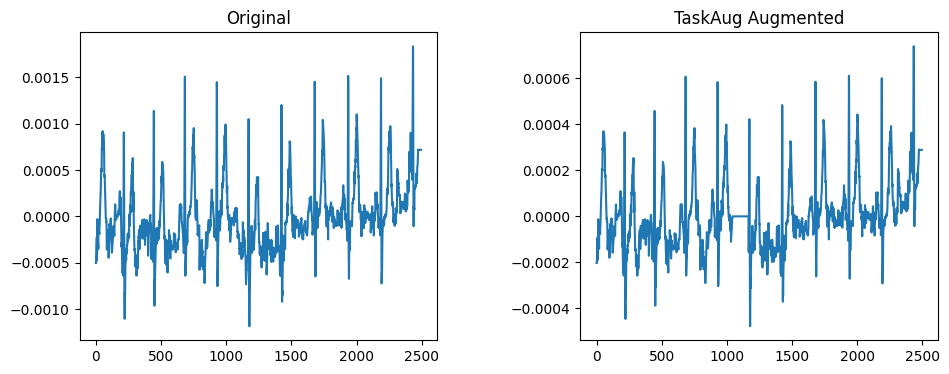

In [177]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 4))

plt.subplot(1, 4, 1)
plt.plot(original_signal.detach().numpy())
plt.title('Original')

plt.subplot(1, 4, 2)
plt.plot(aug1.detach().numpy())
plt.title('TaskAug Augmented')

plt.subplots_adjust(wspace=0.4)  # Add this line
# Or use plt.tight_layout() instead
plt.show()
# plt.subplot(1, 4, 3)
# plt.plot(aug2.detach().numpy())
# plt.title('MI Augmented 2')

# plt.subplot(1, 4, 4)
# plt.plot(aug3.detach().numpy())
# plt.title('MI Augmented 3')

# plt.tight_layout()
# plt.show()

In [178]:
# Now, make sure their leading dimension is the same
print(input_tensor.shape)  # (N, 12, 2496)
print(labels.shape)  

torch.Size([128, 12, 2496])
torch.Size([128])


In [179]:
from sklearn.metrics import roc_auc_score, average_precision_score

all_labels = []
all_probs = []
all_ecg = []

for x_ecg, labels in test_dataloader:
    with torch.no_grad():
        probs = torch.sigmoid(model(x_ecg.to(device)))  # Shape: (batch, tasks)
    all_labels.append(labels.cpu())
    all_probs.append(probs.cpu())
    all_ecg.append(x_ecg.cpu())

all_labels = torch.cat(all_labels)
all_probs = torch.cat(all_probs)
all_ecg = torch.cat(all_ecg)

y_true = all_labels.numpy()
y_score = all_probs.numpy()
auroc = roc_auc_score(y_true, y_score)
auprc = average_precision_score(y_true, y_score)
print(f"STTC AUROC={auroc:.3f}, STTC AUPRC={auprc:.3f}")


STTC AUROC=0.890, STTC AUPRC=0.731


# SMOTE

In [180]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [181]:
print(input_tensor.shape)

torch.Size([128, 12, 2496])


In [182]:
# print(input_np.shape)    # Should be (N, 12, 2496)
# print(all_labels.shape)

print(all_ecg.shape)    # (128, 12, 2496)
print(all_labels.shape) 

# Now, make sure their leading dimension is the same
print(input_tensor.shape)  # (N, 12, 2496)
print(labels.shape)        # (N,)


torch.Size([2198, 12, 2496])
torch.Size([2198])
torch.Size([128, 12, 2496])
torch.Size([22])


In [183]:
import numpy as np
import torch
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import TensorDataset, DataLoader

# ---- 0. Assume you already have these ----
# all_ecg: shape (N_total, 12, 2496), torch.Tensor or np.ndarray
# all_labels: shape (N_total,), torch.Tensor or np.ndarray

# If torch tensors, let's move to numpy for indexing
if isinstance(all_ecg, torch.Tensor):
    all_ecg_np = all_ecg.cpu().numpy()
else:
    all_ecg_np = all_ecg

if isinstance(all_labels, torch.Tensor):
    all_labels_np = all_labels.cpu().numpy()
else:
    all_labels_np = all_labels

# ---- 1. STRATIFIED SUBSET (ensure both classes represented) ----
subset_size = 256   # Choose as needed; must have enough minority samples
sss = StratifiedShuffleSplit(n_splits=1, train_size=subset_size, random_state=42)
for train_idx, _ in sss.split(all_ecg_np, all_labels_np):
    subset_ecg = all_ecg_np[train_idx]
    subset_labels = all_labels_np[train_idx]

# ---- 2. CHECK CLASS BALANCE ----
unique, counts = np.unique(subset_labels, return_counts=True)
print("Class counts in subset:", dict(zip(unique, counts)))
min_count = min(counts)
if min_count < 2:
    raise ValueError("Too few samples in a class for SMOTE! Increase subset_size or choose new split.")

# ---- 3. FLATTEN FOR SMOTE ----
N, n_leads, n_timesteps = subset_ecg.shape
X_flat = subset_ecg.reshape(N, n_leads * n_timesteps)
y_flat = subset_labels

# ---- 4. SET SMOTE k_neighbors ----
# SMOTE requires k_neighbors < min_class_size
k_neighbors = min(5, min_count - 1)  # (Default is 5, must be < min class size)
if k_neighbors < 1:
    raise ValueError("SMOTE needs at least 2 samples in minority class.")

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)

# ---- 5. APPLY SMOTE ----
X_resampled_flat, y_resampled = smote.fit_resample(X_flat, y_flat)
print("SMOTE generated samples:", X_resampled_flat.shape[0])

# ---- 6. RESHAPE BACK TO (samples, 12, 2496) ----
X_resampled = X_resampled_flat.reshape(-1, n_leads, n_timesteps)

# ---- 7. CONVERT TO TORCH TENSORS ----
X_tensor_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor_resampled = torch.tensor(y_resampled, dtype=torch.long)

# ---- 8. DATALOADER FOR TRAINING ----
train_dataset = TensorDataset(X_tensor_resampled, y_tensor_resampled)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# ---- 9. INTEGRATE: TRAINING LOOP (template) ---- 
# for epoch in range(num_epochs):
#     for batch_ecg, batch_labels in train_loader:
#         ... your training code ...

# (You can now use train_loader to feed your model.)

Class counts in subset: {0.0: 195, 1.0: 61}
SMOTE generated samples: 390


In [184]:
print(X_flat.shape)
print(input_np.shape)

(256, 29952)
(128, 12, 2496)


In [185]:
# Assume X_tensor_resampled, y_tensor_resampled, model, criterion, optimizer, device defined above

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_tensor_resampled, y_tensor_resampled)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

model = resnet18(num_outputs=1)
model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()  # For binary
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch).squeeze()
        loss = criterion(output, y_batch.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}')

Epoch 1, Loss: 0.7321
Epoch 2, Loss: 0.6752
Epoch 3, Loss: 0.4676
Epoch 4, Loss: 0.3086
Epoch 5, Loss: 0.3236
Epoch 6, Loss: 0.2669
Epoch 7, Loss: 0.1875
Epoch 8, Loss: 0.1649
Epoch 9, Loss: 0.1522
Epoch 10, Loss: 0.1125
Epoch 11, Loss: 0.1771
Epoch 12, Loss: 0.1537
Epoch 13, Loss: 0.6735
Epoch 14, Loss: 0.4475
Epoch 15, Loss: 0.2195
Epoch 16, Loss: 0.2821
Epoch 17, Loss: 0.1788
Epoch 18, Loss: 0.2234
Epoch 19, Loss: 0.1633
Epoch 20, Loss: 0.1752
Epoch 21, Loss: 0.1640
Epoch 22, Loss: 0.4318
Epoch 23, Loss: 0.2086
Epoch 24, Loss: 0.3528
Epoch 25, Loss: 0.2091
Epoch 26, Loss: 0.2017
Epoch 27, Loss: 0.2282
Epoch 28, Loss: 0.1844
Epoch 29, Loss: 0.1296
Epoch 30, Loss: 0.2803
Epoch 31, Loss: 0.1673
Epoch 32, Loss: 0.3710
Epoch 33, Loss: 0.1608
Epoch 34, Loss: 0.1680
Epoch 35, Loss: 0.2089
Epoch 36, Loss: 0.1293
Epoch 37, Loss: 0.1088
Epoch 38, Loss: 0.2138
Epoch 39, Loss: 0.0968
Epoch 40, Loss: 0.1132
Epoch 41, Loss: 0.2849
Epoch 42, Loss: 0.1029
Epoch 43, Loss: 0.1522
Epoch 44, Loss: 0.10

In [186]:
sample_idx = 0  # (change this to the index of your chosen sample)
lead_idx = 0    # (choose the lead to plot, e.g., 0 for Lead I)
original_signal = input_tensor[sample_idx, lead_idx, :].cpu().numpy()

In [187]:
import numpy as np

# X_resampled: (n_resampled, 12, 2496), y_resampled: (n_resampled,)
original_label = labels_np[sample_idx]
# Find all indices of SMOTE data with the same label
same_label_idx = np.where(y_resampled == original_label)[0]

# Choose one or a few to visualize (first synthetic, or random from above input size)
smote_idx = same_label_idx[len(labels_np)]  # First synthetic sample, beyond the originals

smote_sample = X_resampled[smote_idx, lead_idx, :]  # shape (2496,)

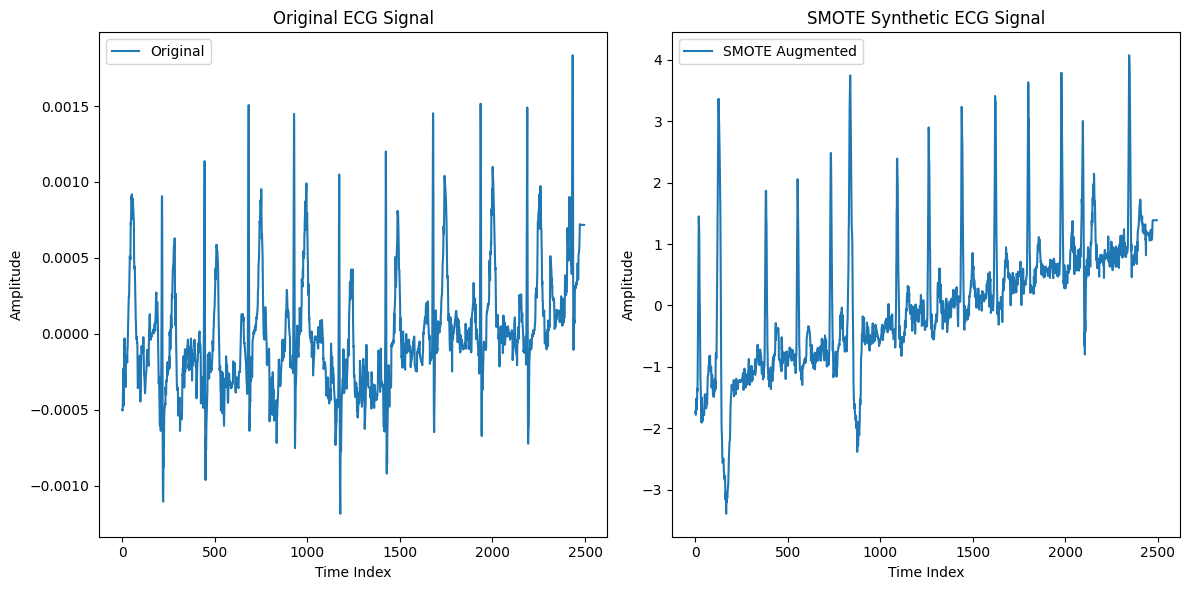

In [188]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Original signal subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(original_signal, label='Original')
plt.title('Original ECG Signal')
plt.xlabel('Time Index')
plt.ylabel('Amplitude')
plt.legend()


plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(smote_sample, label='SMOTE Augmented')
plt.title('SMOTE Synthetic ECG Signal')
plt.xlabel('Time Index')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [189]:
from sklearn.metrics import roc_auc_score, average_precision_score
import torch

all_labels = []
all_probs = []
all_ecg = []

for x_ecg, labels in test_dataloader:  # or test_loader
    with torch.no_grad():
        probs = torch.sigmoid(model(x_ecg.to(device)))
    all_labels.append(labels.cpu())
    all_probs.append(probs.cpu())
    all_ecg.append(x_ecg.cpu())

all_labels = torch.cat(all_labels)
all_probs = torch.cat(all_probs)
all_ecg = torch.cat(all_ecg)

y_true = all_labels.numpy()
y_score = all_probs.numpy()
auroc = roc_auc_score(y_true, y_score)
auprc = average_precision_score(y_true, y_score)
print(f"SMOTE STTC AUROC={auroc:.3f}, SMOTE STTC AUPRC={auprc:.3f}")

SMOTE STTC AUROC=0.846, SMOTE STTC AUPRC=0.654


# Ablation

## Adding Gaussian Noise to ECG data

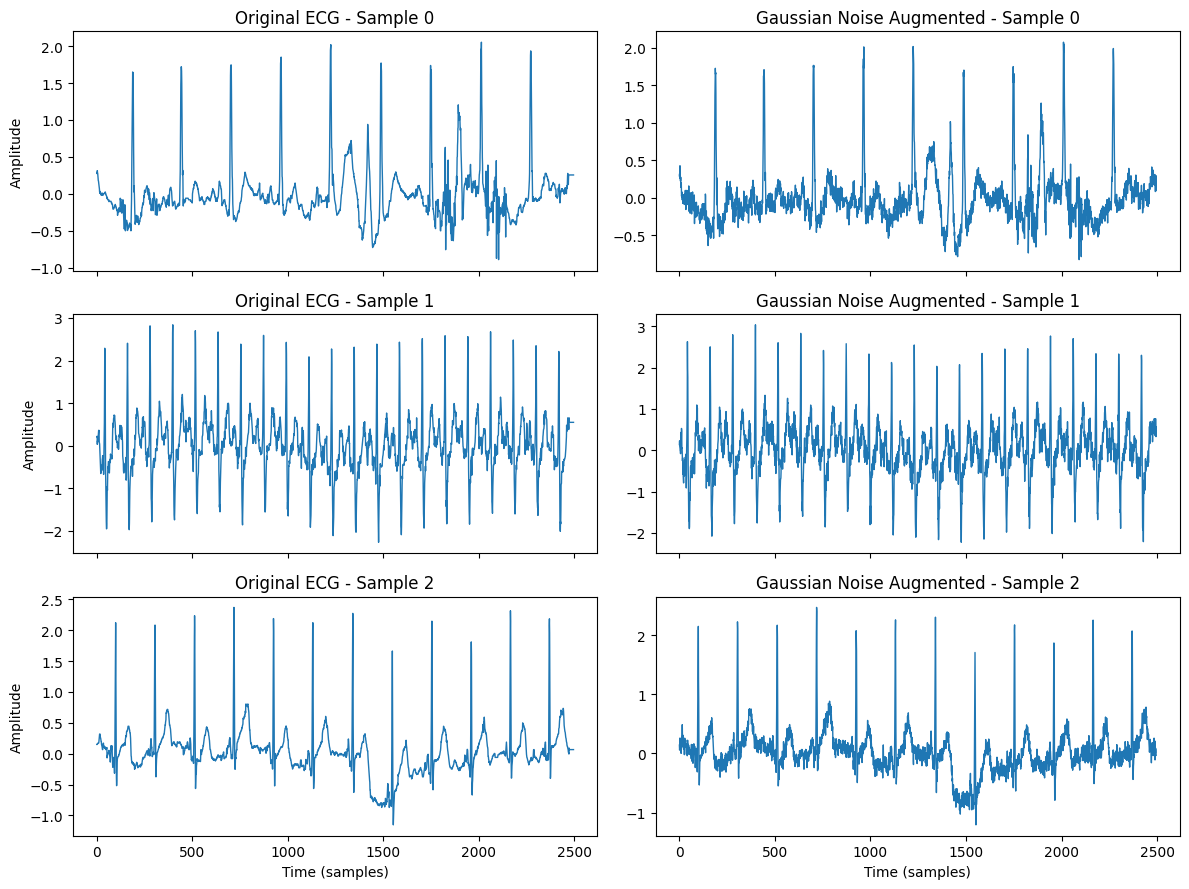

In [191]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ------- 1. Select a Subset of ECG Data -------
# Assume: 'all_ecg' is (N_samples, 12, 2496) as a torch tensor or numpy array

N_to_view = 3   # Number of examples to visualize
lead_to_plot = 0  # e.g., Lead I

# Randomly select indices from full set (or pick first N for demonstration)
subset_indices = np.random.choice(all_ecg.shape[0], size=N_to_view, replace=False)
ecg_subset = all_ecg[subset_indices]   # Shape: (N_to_view, 12, 2496)
if isinstance(ecg_subset, torch.Tensor):
    ecg_subset = ecg_subset.cpu().numpy()

# ------- 2. Define Gaussian Noise Augmentation -------
def add_gaussian_noise(ecg_signal, noise_std=0.1):
    """ecg_signal: (12, 2496) array; noise_std: fraction of signal stddev."""
    std_per_lead = ecg_signal.std(axis=-1, keepdims=True)   # shape: (12, 1)
    noise = np.random.randn(*ecg_signal.shape) * (noise_std * std_per_lead)
    return ecg_signal + noise

# ------- 3. Apply Augmentation to Subset -------
noise_std = 0.2  # Adjust as needed (e.g., 0.05 to 0.3)
ecg_noisy_subset = np.array([add_gaussian_noise(ecg, noise_std) for ecg in ecg_subset])

# ------- 4. Visualize the Effects Side-by-Side -------
time = np.arange(ecg_subset.shape[-1])

fig, axes = plt.subplots(N_to_view, 2, figsize=(12, 3 * N_to_view), sharex=True)
for i in range(N_to_view):
    # Original
    axes[i, 0].plot(time, ecg_subset[i, lead_to_plot], lw=1)
    axes[i, 0].set_title(f"Original ECG - Sample {i}")
    axes[i, 0].set_ylabel("Amplitude")

    # Noisy
    axes[i, 1].plot(time, ecg_noisy_subset[i, lead_to_plot], lw=1)
    axes[i, 1].set_title(f"Gaussian Noise Augmented - Sample {i}")

for ax in axes[-1]: ax.set_xlabel("Time (samples)")
plt.tight_layout()
plt.show()